<h1 style="color:#3498DB">Transfer Learning Cats Dogs</h1>

In [1]:
import os
import math
import zipfile
import warnings
import random
# import wget
import datetime

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import TensorBoard

%matplotlib inline
%load_ext tensorboard
warnings.filterwarnings('ignore')

<h3 style=color:#3498DB>///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////</h3>

<h1 style="color:#3498DB">Download The Data Archive File</h1>

In [4]:
!wget --no-check-certificate https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

--2022-04-20 20:32:18--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.5.128, 74.125.133.128, 74.125.140.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.5.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M  53.9MB/s    in 1.2s    

2022-04-20 20:32:20 (53.9 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [6]:
# wget.download('https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip', 'tmp_transfer\\')

<h1 style="color:#3498DB">Extract The Data Archive</h1>

In [20]:
# Extract the archive
zip_file_name = 'cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(zip_file_name, 'r')
zip_ref.extractall('tmp_transfer/')
zip_ref.close()

# Assign training and validation set directories

train_dir = os.path.join('tmp_transfer/cats_and_dogs_filtered', 'train')
validation_dir = os.path.join('tmp_transfer/cats_and_dogs_filtered', 'validation')

train_dir, validation_dir

('tmp_transfer/cats_and_dogs_filtered/train',
 'tmp_transfer/cats_and_dogs_filtered/validation')

<h3 style=color:#3498DB>///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////</h3>

<h1 style="color:#3498DB">Build The Model</h1>

<h2 style="color:#3498DB">Create Inception Model and download Weights file</h2>

In [9]:
# # Download the pre-trained weights. No top means it excludes the fully connected layer it uses for classification.
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2022-04-20 20:34:04--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.5.128, 74.125.133.128, 74.125.140.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.5.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

inception_v3_weight 100%[===================>]  83.84M  42.6MB/s    in 2.0s    

2022-04-20 20:34:07 (42.6 MB/s) - ‘inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [7]:
# download_http = "https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
# wget.download(download_http, 'tmp_transfer\\')

In [10]:
weights_file_location = 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [11]:
pretrained_model = InceptionV3(
                                include_top=False,
                                input_shape=(150,150,3),
                                weights=weights_file_location)

# Freeze the weights of the layers.
for layer in pretrained_model.layers:
    layer.trainable = False

In [12]:
pretrained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

In [13]:
len(pretrained_model.layers)

311

<h2 style="color:#3498DB">Choose `mixed_7` as the last layer of your base model</h2>

In [14]:
last_layer = pretrained_model.get_layer('mixed7')

print('last layer output shape: ', last_layer.output_shape)

last_output = last_layer.output
last_output

last layer output shape:  (None, 7, 7, 768)


<KerasTensor: shape=(None, 7, 7, 768) dtype=float32 (created by layer 'mixed7')>

<h2 style="color:#3498DB">Add dense layers</h2>

In [15]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)     

<h2 style="color:#3498DB">Append the dense network to the base model</h2>

In [16]:
model = keras.Model(pretrained_model.input, x)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [17]:
len(model.layers)

233

In [18]:
from tensorflow.keras.optimizers import RMSprop

# Set the training parameters
model.compile(optimizer = RMSprop(learning_rate=0.0001), 
                        loss = 'binary_crossentropy', 
                        metrics = ['accuracy'])

<h3 style=color:#3498DB>///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////</h3>

<h3 style="color:#3498DB">ImageDataGenerator</h3>

In [21]:
from keras.preprocessing.image import ImageDataGenerator

# Generator Objects
train_datagen = ImageDataGenerator(
                                   rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest'
                                   )

validation_datagen = ImageDataGenerator(rescale=1./255)

# Flowing from dir

train_generator = train_datagen.flow_from_directory(
                                                    train_dir,
                                                    target_size=(150, 150),
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    )

validation_generator = validation_datagen.flow_from_directory(
                                                              validation_dir,
                                                              target_size=(150, 150),
                                                              batch_size=20,
                                                              class_mode='binary'
                                                              )

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


<h3 style="color:#3498DB">Tensorboard callback class</h3>

In [22]:
project_name = 'transfer_cats_dogs'
log_dir_customized = "tmp_transfer\\logs\\"+project_name+"\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M")
Tensorboard_callback = TensorBoard(
                                   log_dir=log_dir_customized,
                                   histogram_freq=1,
                                   write_graph=True,
                                   write_images=True,
                                   write_steps_per_second=True,
                                   profile_batch=1,
                                   embeddings_freq=1,
                                   )

<h3 style="color:#3498DB">Create a model object and train it</h3>

In [23]:
history = model.fit(
                    train_generator,
                    steps_per_epoch=100,
                    epochs=20,
                    validation_data=validation_generator,
                    validation_steps=50,
                    verbose=1,
                    callbacks=[Tensorboard_callback]
                    )

Epoch 1/20
100/100 [==============================] - 69s 545ms/step - loss: 0.4748 - accuracy: 0.7870 - val_loss: 0.1759 - val_accuracy: 0.9210
Epoch 2/20
100/100 [==============================] - 56s 561ms/step - loss: 0.3396 - accuracy: 0.8640 - val_loss: 0.1057 - val_accuracy: 0.9570
Epoch 3/20
100/100 [==============================] - 55s 549ms/step - loss: 0.3038 - accuracy: 0.8710 - val_loss: 0.1160 - val_accuracy: 0.9490
Epoch 4/20
100/100 [==============================] - 54s 544ms/step - loss: 0.2898 - accuracy: 0.8800 - val_loss: 0.1033 - val_accuracy: 0.9600
Epoch 5/20
100/100 [==============================] - 55s 548ms/step - loss: 0.2797 - accuracy: 0.8905 - val_loss: 0.1353 - val_accuracy: 0.9490
Epoch 6/20
100/100 [==============================] - 54s 547ms/step - loss: 0.2569 - accuracy: 0.8945 - val_loss: 0.1034 - val_accuracy: 0.9680
Epoch 7/20
100/100 [==============================] - 54s 544ms/step - loss: 0.2754 - accuracy: 0.8955 - val_loss: 0.1332 - val_ac

In [31]:
# %tensorboard --logdir tmp_transfer\logs\Augmentation_cats_dogs\20220420-2037\

<h3 style=color:#3498DB>///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////</h3>

<h3 style="color:#3498DB">Plot Loss and Accuracy</h3>

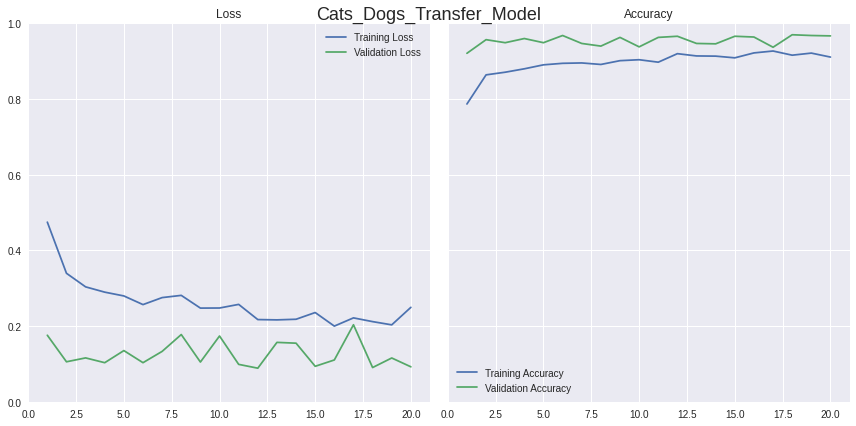

In [26]:
ModelName = 'Cats_Dogs_Transfer_Model'

def plot_loss_accuracy(modelhistory, modelname):
    
    loss     = modelhistory.history['loss']
    val_loss = modelhistory.history['val_loss']
    acc      = modelhistory.history['accuracy']
    val_acc  = modelhistory.history['val_accuracy']

    epochs   = range(1,len(acc)+1) # Get number of epochs

    plt.style.use('seaborn')
    
    # Create Subplots System
    fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)

    # Change Figure Size
    fig.set_size_inches(12, 6)

    # Fig Name
    fig.suptitle(modelname, fontsize=18)
    
    # First Axies
    ax1.plot(epochs, loss, label="Training Loss")
    ax1.plot(epochs, val_loss, label="Validation Loss")
    ax1.set_title('Loss')
    ax1.set_xlim(0,21.0)
    ax1.set_ylim(0,1.0)
    ax1.legend()

    # Second Axies
    ax2.plot(epochs, acc, label="Training Accuracy")
    ax2.plot(epochs, val_acc, label="Validation Accuracy")
    ax2.set_title('Accuracy')
    ax2.set_xlim(0,21.0)
    ax2.legend()

    # Change Padding to Tight
    plt.tight_layout()

    # Show The Figure
    plt.show()

    # Save The Figure To JPG File
    fig.savefig('tmp_transfer\\'+modelname+'.jpg')
    
plot_loss_accuracy(history, ModelName)

<h3 style="color:#3498DB">Save Model To h5 File</h3>

In [27]:
model.save('tmp_transfer\\'+ModelName+'.h5')

<h3 style=color:#3498DB>///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////</h3>

<h1 style="color:#3498DB">Test The Model</h1>

In [38]:
## CODE BLOCK FOR NON-SAFARI BROWSERS
## SAFARI USERS: PLEASE SKIP THIS BLOCK AND RUN THE NEXT ONE INSTEAD

import numpy as np

from google.colab import files
from keras.preprocessing import image

uploaded=files.upload()

for fn in uploaded.keys():
 
    # predicting images
    path='/content/' + fn
    img=image.load_img(path, target_size=(150, 150))
  
    x=image.img_to_array(img)
    x /= 255
    x=np.expand_dims(x, axis=0)
    images = np.vstack([x])
  
    classes = model.predict(images, batch_size=10)
  
    print(classes[0])
  
    if classes[0]>0.5:
        print(fn + " is a dog")
    else:
        print(fn + " is a cat")

Saving cat 01.jpg to cat 01.jpg
Saving cat 02.jpg to cat 02.jpg
Saving cat 03.jpg to cat 03.jpg
Saving cat 04.jpg to cat 04.jpg
Saving cat 05.jpg to cat 05.jpg
Saving cat 06.jpg to cat 06.jpg
Saving dog 01.jpeg to dog 01.jpeg
Saving dog 02.jpg to dog 02.jpg
Saving dog 03.jpg to dog 03.jpg
Saving dog 04.jpg to dog 04.jpg
Saving dog 05.jpg to dog 05.jpg
[1.10679415e-14]
cat 01.jpg is a cat
[5.4870425e-10]
cat 02.jpg is a cat
[4.086464e-06]
cat 03.jpg is a cat
[0.06048723]
cat 04.jpg is a cat
[1.5027839e-06]
cat 05.jpg is a cat
[3.9096955e-07]
cat 06.jpg is a cat
[0.36661544]
dog 01.jpeg is a cat
[0.00057138]
dog 02.jpg is a cat
[1.]
dog 03.jpg is a dog
[0.9301368]
dog 04.jpg is a dog
[1.]
dog 05.jpg is a dog
